# Description
This script compares cest values of regions within network vs between network.


## Import Packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

### Set Variables and Paths

In [2]:
# Set Variables
fieldstrength = '3T'
atlas = 'HO_sub'
bblids = []
sesids = []
nmaps = ["NMDA", "mGluR5", "GABA","D2"]
diag_scores = ["dx_pscat", "hstatus","sex", "age", "race","ethnic"] # ,"axis1_desc1","axis1_stat1"
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
#subjlist = subjlist[subjlist['fieldstrength'] == fieldstrength]
#subjs = subjlist['BBLID']

# Import group dataframes and set indices
#subjlist = pd.read_csv(path + "data/pipeline_input_all_subj.csv", sep=',') 
cestmat = pd.read_csv("cest_parcelmat" + fieldstrength + atlas + ".csv", sep=',') 
#fcmat = pd.read_csv("fc_parcelmat_" + fieldstrength + atlas + ".csv", sep=',')
#rehomat = pd.read_csv("reho_parcelmat" + fieldstrength + atlas + ".csv", sep=',')
grp_df = pd.read_csv("filtered_grp_df" + fieldstrength + atlas + ".csv", sep=',')

# Reformat some dfs
cestmat.set_index('BBLID', inplace = True)
#fcmat.set_index('BBLID', inplace = True)
#rehomat.set_index('BBLID', inplace = True)
grp_df.set_index('BBLID', inplace = True)


### Create functions

In [7]:
def filter(df, filter_list):
    filtered_columns = [col for col in df.columns if not any(substring in col for substring in filter_list)]
    return df[filtered_columns]

def keep(df, keep_list):
    keep_columns = [col for col in df.columns if any(substring in col for substring in keep_list)]
    return df[keep_columns]   

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            valid_data = df[[col,col2]].dropna()
            if not valid_data.empty:
                _ , p = pearsonr(valid_data[col],valid_data[col2])
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            else:
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = np.nan
    return p_matrix

### Create correlation matrix and heatmap

In [3]:
# Filter df to exclude subj info
subj_info = ["BBLID"] + ["Session"] + diag_scores + ["count"]
heat_df = filter(grp_df, subj_info)
print(grp_df)

        Unnamed: 0  Session dx_pscat hstatus  sex   age  race  ethnic  \
BBLID                                                                   
20303            0    12276  noDSMdx      NC  1.0  19.2   1.0     2.0   
90217            1    12064      pro     PRO  2.0  25.0   1.0     2.0   
88608            2  motive2      psy     PRO  1.0  25.4   2.0     2.0   
21874            3    12043      NaN     PSY  2.0  24.1   1.0     2.0   
94288            4    11948  noDSMdx      NC  1.0  22.7   1.0     2.0   
...            ...      ...      ...     ...  ...   ...   ...     ...   
135085          81  motive1      pro     PRO  2.0  18.9   1.0     2.0   
135277          82    12277      psy     PSY  2.0  30.2   2.0     2.0   
117397          83    10582    other    PROR  1.0  20.2   2.0     2.0   
87646           84    10496      NaN     NaN  NaN   NaN   NaN     NaN   
93242           85    12525    other    PROR  1.0  25.3   1.0     2.0   

        NZMean_8  NZcount_8  ...  NZMean_14  NZcou

In [4]:
# Correlation matrix
corr_df=heat_df.corr()
#plt.figure(figsize=(11,9))
#sns.heatmap(corr_df, annot=False, cmap='coolwarm',linewidth=0.7)
#plt.title('Glu-FC Heatmap\nGross network architecture emerges more strongly in fc+reho\nbut also evident in within-Glu correlations')
#plt.tick_params(axis='both', which='major', labelsize=10)
#plt.show()

AttributeError: 'filter' object has no attribute 'corr'

### Correlation matrix after masking out the significant ones

In [122]:
#pvals = corr_sig(heat_df)
#mask01 = np.invert(np.tril(pvals<0.01))
#mask001 = np.invert(np.tril(pvals<0.001))

In [115]:
#plt.figure(figsize=(11,9))
#sns.heatmap(corr_df, mask=mask01, annot=False, cmap='coolwarm',linewidth=0.7)
#plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.001')
#plt.show()

#masked_cestcorr = cestcorr_df.where(pvals <= .0001)

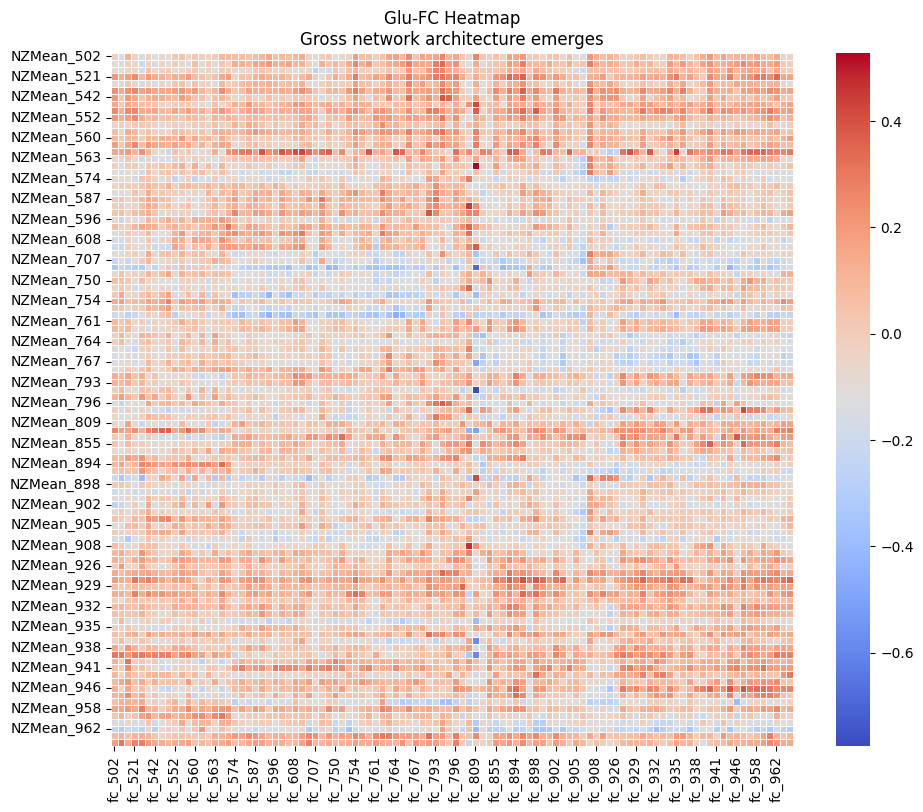

In [85]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

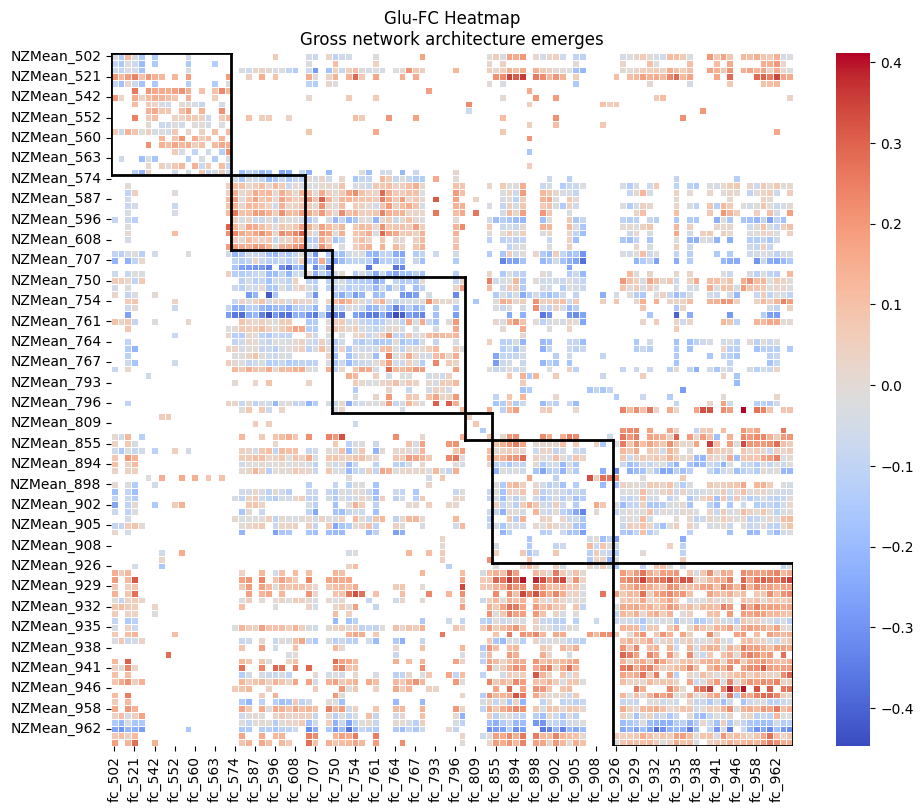

In [87]:
## CEST-FC Heat map with network boxes.

# List of parcel names (from the index/columns of your cestcorr_df)
parcel_names = cestcorr_df.index.tolist()

# Define the network numbers to search for
networks = {
    'Visual': [502, 567],
    'Somatomotor': [574, 613],
    'Dorsal Attention': [692, 712],
    'Salience': [750, 797],
    'Limbic': [807, 812 ],
    'Control': [855, 910],
    'Default': [926, 974]
    # Add other networks with their corresponding numbers
}

# Find the indices for each network
network_boundaries = []
for network, nums in networks.items():
    indices = [i for i, name in enumerate(parcel_names) if any(str(num) in name for num in nums)]
    if indices:
        network_boundaries.append((min(indices), max(indices)))

# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm', linewidth=0.7)

# Draw the black boxes around network boundaries
for (start, end) in network_boundaries:
    plt.plot([start, end+1], [start, start], color='black', lw=2)  # Top line
    plt.plot([start, end+1], [end+1, end+1], color='black', lw=2)  # Bottom line
    plt.plot([start, start], [start, end+1], color='black', lw=2)  # Left line
    plt.plot([end+1, end+1], [start, end+1], color='black', lw=2)  # Right line

plt.title('Glu-FC Heatmap\nGross network architecture emerges')
plt.show()

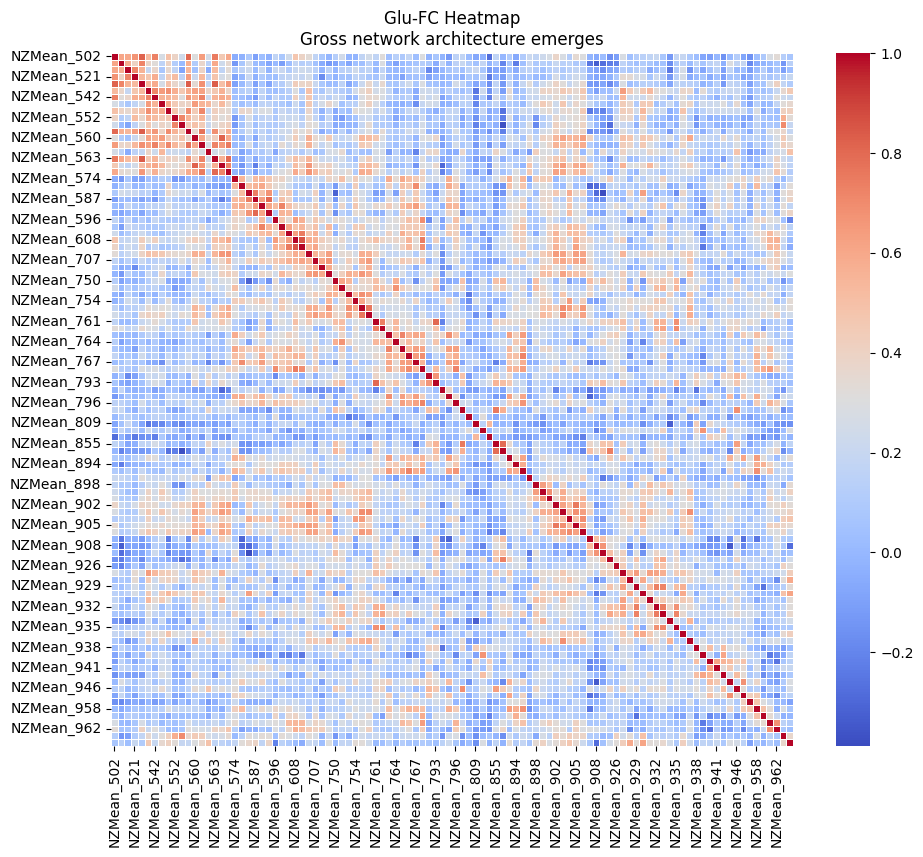

In [88]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

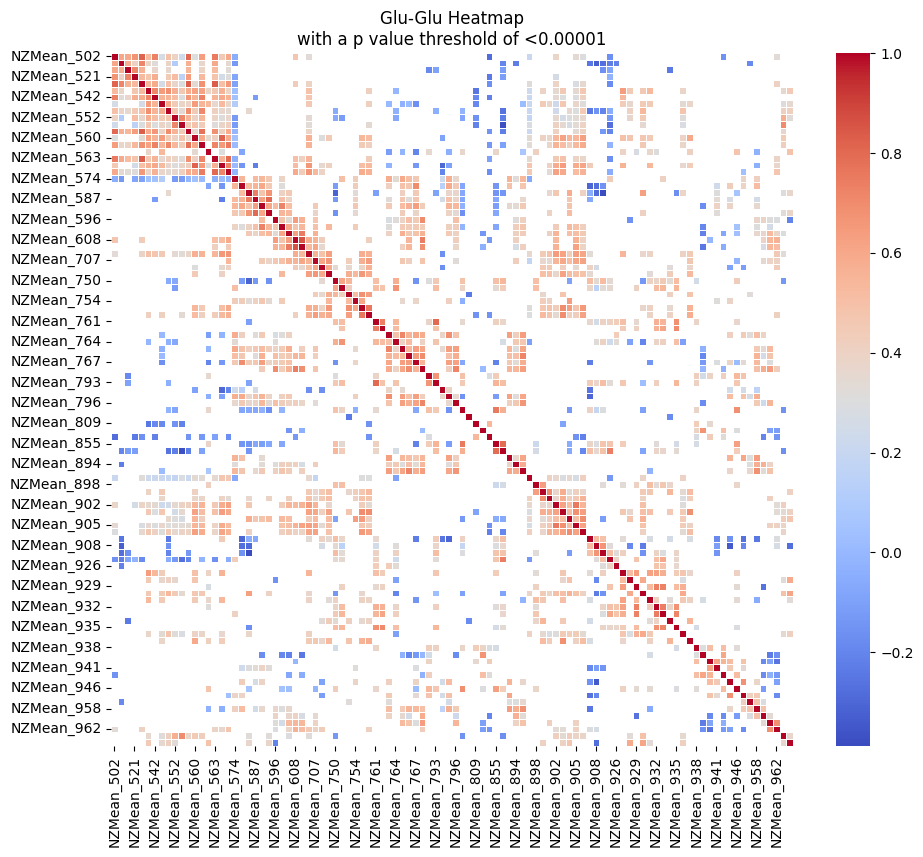

In [89]:
# Keep only signficant values
pvals = corr_sig(cestcorr_df) #

#cestpvals = cestcorr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
mask01 = np.invert(np.tril(pvals<0.01))
mask02 = np.invert(pvals<0.00001)

plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-Glu Heatmap\nwith a p value threshold of <0.00001')
plt.show()

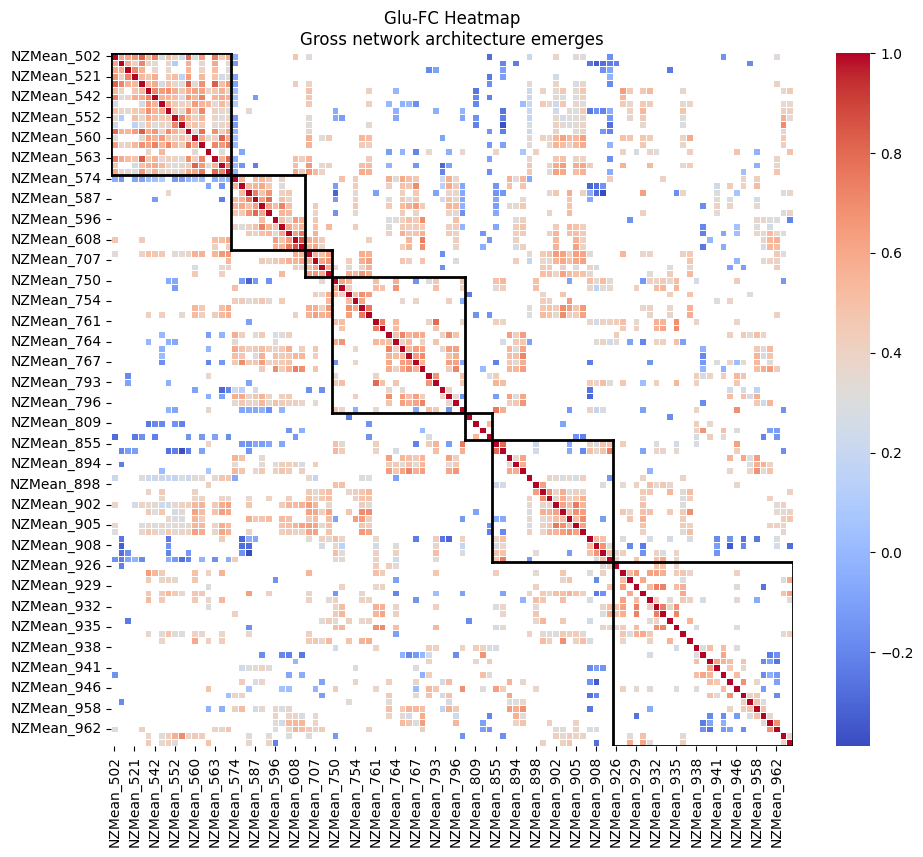

In [90]:
## CEST-FC Heat map with network boxes.

# List of parcel names (from the index/columns of your cestcorr_df)
parcel_names = cestcorr_df.index.tolist()

# Define the network numbers to search for
networks = {
    'Visual': [502, 567],
    'Somatomotor': [574, 613],
    'Dorsal Attention': [692, 712],
    'Salience': [750, 797],
    'Limbic': [807, 812 ],
    'Control': [855, 910],
    'Default': [926, 974]
    # Add other networks with their corresponding numbers
}

# Find the indices for each network
network_boundaries = []
for network, nums in networks.items():
    indices = [i for i, name in enumerate(parcel_names) if any(str(num) in name for num in nums)]
    if indices:
        network_boundaries.append((min(indices), max(indices)))

# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)

# Draw the black boxes around network boundaries
for (start, end) in network_boundaries:
    plt.plot([start, end+1], [start, start], color='black', lw=2)  # Top line
    plt.plot([start, end+1], [end+1, end+1], color='black', lw=2)  # Bottom line
    plt.plot([start, start], [start, end+1], color='black', lw=2)  # Left line
    plt.plot([end+1, end+1], [start, end+1], color='black', lw=2)  # Right line

plt.title('Glu-FC Heatmap\nGross network architecture emerges')
plt.show()

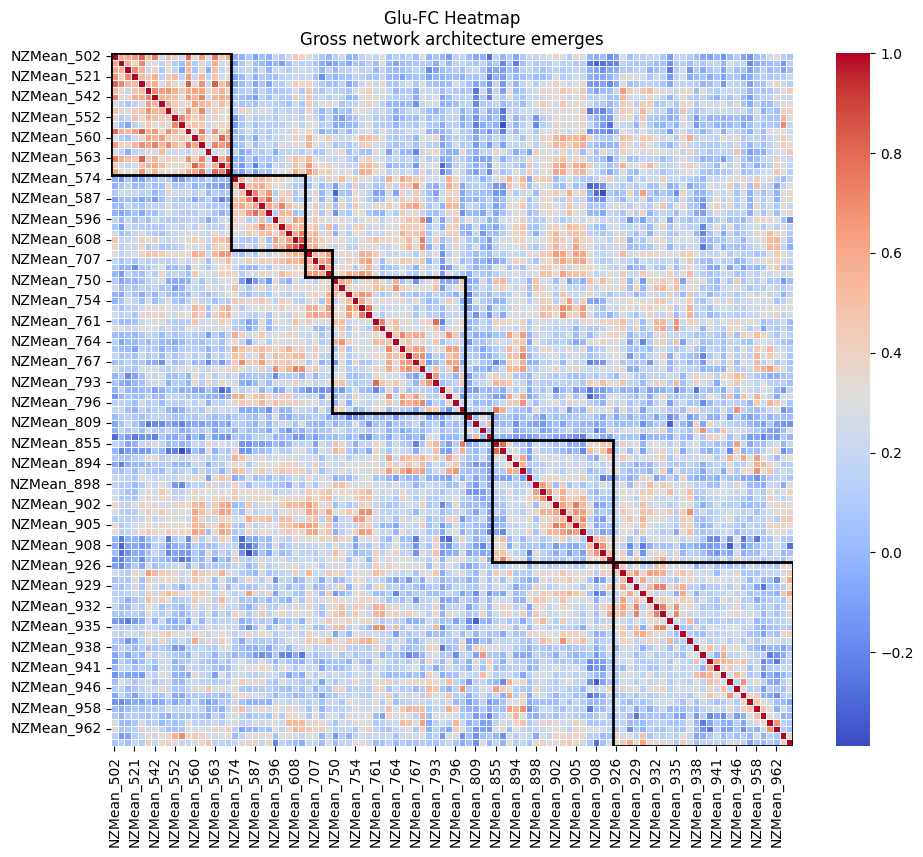

In [47]:
## Heat map with network boxes.

# Keep only signficant values
cestfc = corr_df.filter(like="NZ", axis=0).filter(like="fc", axis=1)
pvals = corr_sig(cestfc)
pvals
mask01 = np.invert(np.tril(pvals<0.01))
mask02 = np.invert(pvals<0.0000001)


plt.figure(figsize=(11,9))
sns.heatmap(cestcorr_df, mask=mask02, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.01')
plt.show()



# List of parcel names (from the index/columns of your cestcorr_df)
parcel_names = cestcorr_df.index.tolist()

# Define the network numbers to search for
networks = {
    'Visual': [502, 567],
    'Somatomotor': [574, 613],
    'Dorsal Attention': [692, 712],
    'Salience': [750, 797],
    'Limbic': [807, 812 ],
    'Control': [855, 910],
    'Default': [926, 974]
    # Add other networks with their corresponding numbers
}

# Find the indices for each network
network_boundaries = []
for network, nums in networks.items():
    indices = [i for i, name in enumerate(parcel_names) if any(str(num) in name for num in nums)]
    if indices:
        network_boundaries.append((min(indices), max(indices)))

# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(cestcorr_df, annot=False, cmap='coolwarm', linewidth=0.7)

# Draw the black boxes around network boundaries
for (start, end) in network_boundaries:
    plt.plot([start, end+1], [start, start], color='black', lw=2)  # Top line
    plt.plot([start, end+1], [end+1, end+1], color='black', lw=2)  # Bottom line
    plt.plot([start, start], [start, end+1], color='black', lw=2)  # Left line
    plt.plot([end+1, end+1], [start, end+1], color='black', lw=2)  # Right line

plt.title('Glu-FC Heatmap\nGross network architecture emerges')
plt.show()

### Within- vs between-network

In [49]:
def within_between(corr_df, parcels,symmetric):
    # Returns average correlation within and between network.
    ins = []
    outs = []
    for row in corr_df.index:
        for col in corr_df.columns:
            # Within-network: row and column have to contain parcel names
            if any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    ins.append(corr_df.loc[row, col])
                    
            # Between-network: Only row contains parcel name
            elif any(parcel in row for parcel in parcels) and not any(parcel in col for parcel in parcels):
                if not pd.isna(corr_df.loc[row, col]):
                    outs.append(corr_df.loc[row, col])
            if symmetric == False: # Only run columns with parcel name if corr_df is asymmetric
                if not any(parcel in row for parcel in parcels) and any(parcel in col for parcel in parcels):
                    if not pd.isna(corr_df.loc[row, col]):
                        outs.append(corr_df.loc[row, col])
    # Run t test comparing within- vs between-network values
    t, p = sp.stats.ttest_ind(ins,outs)
    # Take avg.
    avgin = np.mean(ins)
    sdin = np.std(ins)
    avgout = np.mean(outs)
    sdout = np.std(outs)
    return (avgin, sdin, avgout, sdout, t,p) 

vis = [str(x) for x in range(500,569)]
mn = [str(x) for x in range(569,659)]
da = [str(x) for x in range(659,721)]
sn = [str(x) for x in range(721,798)]
lim = [str(x) for x in range(798,829)]
ecn = [str(x) for x in range(829,911)]
dmn = [str(x) for x in range(911,980)]

In [50]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(cestcorr_df, vis, True),
    within_between(cestcorr_df, mn, True),
    within_between(cestcorr_df, da, True),
    within_between(cestcorr_df, sn, True),
    within_between(cestcorr_df, lim, True),
    within_between(cestcorr_df, ecn, True),
    within_between(cestcorr_df, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,4.851822e-01,4.744737e-01,6.922882e-01,3.264112e-01,3.858048e-01,2.794729e-01,2.304787e-01
Within_sd,2.278525e-01,2.589540e-01,1.840803e-01,2.587680e-01,3.909330e-01,2.770621e-01,2.348931e-01
Between_avg,1.449938e-01,1.931162e-01,2.458706e-01,1.903481e-01,3.910903e-02,1.926098e-01,1.724189e-01
Between_sd,1.660669e-01,1.766957e-01,1.761545e-01,1.761985e-01,1.310982e-01,1.884653e-01,1.622390e-01
t,3.110869e+01,1.559256e+01,9.893984e+00,1.249596e+01,9.038680e+00,6.854906e+00,7.291789e+00
p,5.557708e-171,9.362835e-50,8.042029e-21,1.403693e-34,6.552770e-18,9.714518e-12,3.978981e-13


In [51]:
masked_cestcorr = cestcorr_df.where(pvals <= .0001)

cestdf = pd.DataFrame(zip(
    within_between(masked_cestcorr, vis, True),
    within_between(masked_cestcorr, mn, True),
    within_between(masked_cestcorr, da, True),
    within_between(masked_cestcorr, sn, True),
    within_between(masked_cestcorr, lim, True),
    within_between(masked_cestcorr, ecn, True),
    within_between(masked_cestcorr, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
cestdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
cestdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,5.397691e-01,6.063313e-01,6.922882e-01,5.318295e-01,8.448743e-01,4.467981e-01,4.415832e-01
Within_sd,1.950166e-01,1.928823e-01,1.840803e-01,2.697196e-01,2.193809e-01,3.215880e-01,3.178394e-01
Between_avg,2.040628e-01,2.778817e-01,4.088937e-01,3.039170e-01,-2.976418e-02,3.032648e-01,2.886800e-01
Between_sd,2.673076e-01,2.514458e-01,1.740765e-01,2.537667e-01,2.198574e-01,2.510581e-01,2.319945e-01
t,1.755684e+01,1.098268e+01,6.033539e+00,9.440447e+00,9.177059e+00,5.611092e+00,6.975389e+00
p,1.800659e-56,1.707155e-24,1.453889e-08,9.586148e-20,1.846099e-13,3.046691e-08,7.400873e-12


In [78]:
fcdf = pd.DataFrame(zip(
    within_between(cestfc, vis, True),
    within_between(cestfc, mn, True),
    within_between(cestfc, da, True),
    within_between(cestfc, sn, True),
    within_between(cestfc, lim, True),
    within_between(cestfc, ecn, True),
    within_between(cestfc, dmn, True)),
                          columns = ["Vis","SomMot","DorsAttn","Sal","Limbic","Cont","Default"])
                       
fcdf.index = ["Within_avg", "Within_sd", "Between_avg","Between_sd","t","p"]
fcdf 

,Vis,SomMot,DorsAttn,Sal,Limbic,Cont,Default
Within_avg,3.357875e-02,7.486184e-02,-0.177215,-0.031078,-0.044938,-0.033509,7.696920e-02
Within_sd,1.080365e-01,1.007346e-01,0.135831,0.133377,0.197829,0.123778,1.347199e-01
Between_avg,8.031083e-02,-3.531636e-03,-0.103724,-0.037992,0.042382,-0.011320,3.873417e-02
Between_sd,1.193191e-01,1.149599e-01,0.139306,0.130280,0.136657,0.120031,1.309165e-01
t,-6.498262e+00,7.169117e+00,-2.065325,0.946675,-2.447114,-3.001328,6.707202e+00
p,1.044012e-10,1.367758e-12,0.039526,0.343917,0.014823,0.002724,2.398810e-11


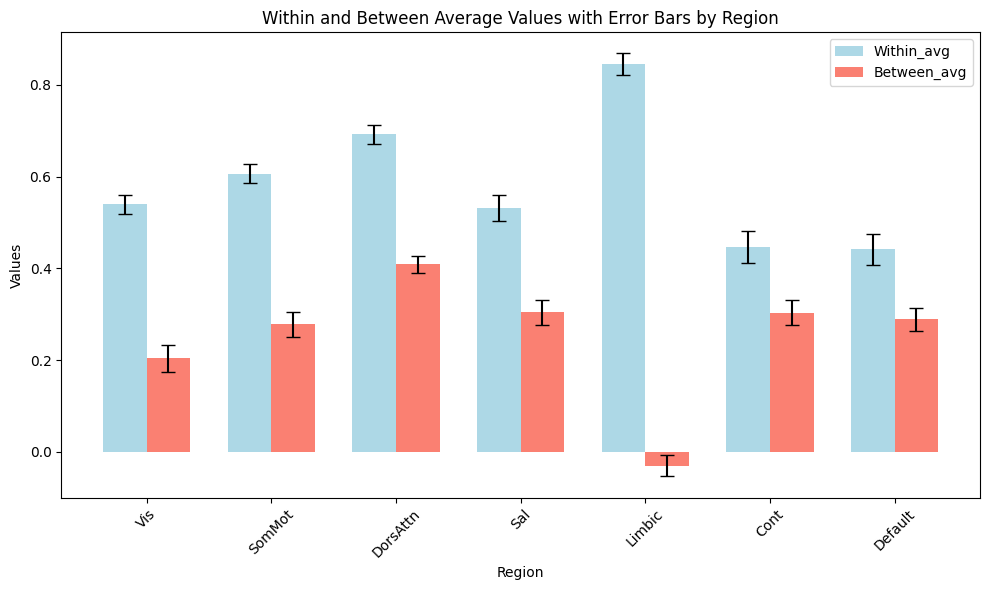

In [79]:
# Make a bar plot comparing within vs between values.
# Extract values
df = cestdf
regions = df.columns
within_avg = df.loc['Within_avg']
within_sd = df.loc['Within_sd']
between_avg = df.loc['Between_avg']
between_sd = df.loc['Between_sd']

# Set positions and width for bars
n = 85 


x = np.arange(len(regions))
width = 0.35

within_se = within_sd / np.sqrt(n)
between_se = between_sd / np.sqrt(n)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot within and between averages with error bars
#ax.bar(x - width/2, within_avg, width, yerr=within_sd, label='Within_avg', capsize=5, color='lightblue')
#ax.bar(x + width/2, between_avg, width, yerr=between_sd, label='Between_avg', capsize=5,color='salmon')
ax.bar(x - width/2, within_avg, width, yerr=within_se, label='Within_avg', capsize=5, color='lightblue')
ax.bar(x + width/2, between_avg, width, yerr=between_se, label='Between_avg', capsize=5, color='salmon')


# Set labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Values')
ax.set_title('Within and Between Average Values with Error Bars by Region')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### NMAP correlations

In [108]:
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
#nmapsdf.columns = nmaps 

# Trim cestmat and keep only the columns with avg values.
cestNZMeans = keep(grp_df, ["NZMean"])
cestavgs = cestNZMeans.mean(axis=0)
# Make new df to store avg nmap values and average CEST values.
glunmaps = nmapsdf.copy()
glunmaps.index = range(1,1001)
glunmaps["CESTavg"] = np.nan
# Add values to new df
for i in range(501,1001):
    cestparcel = f'NZMean_{i}'
    if cestparcel in cestavgs.index:
        #print(cestparcel)
        #print(cestavgs[cestparcel])
        glunmaps.loc[i,"CESTavg"] = cestavgs[cestparcel]
glunmaps = glunmaps.dropna(subset=["CESTavg"])

In [109]:
sorted_df = glunmaps.sort_values(by="CESTavg", ascending=False)  # Use ascending=True if you want to sort in ascending order

print(sorted_df)

            0         1         2    CESTavg
518  5.827461 -1.884991 -0.392477  10.641749
504  6.406018 -0.633749  1.279621  10.161161
532  5.646722 -0.540665  0.404331   9.893395
502  7.192964 -0.377612  2.481264   9.821854
563  4.545387 -0.732697 -0.808888   9.638502
..        ...       ...       ...        ...
946  5.544856 -1.208752 -0.942742   6.847678
938  7.172033  1.548303  1.286203   6.711090
908  4.580144 -3.234550 -1.256276   6.696995
939  6.802049 -0.355992  0.003789   6.460084
811  7.013567  0.647284  0.794431   6.218522

[102 rows x 4 columns]


In [110]:
# Loop through nmaps and make correlation plots
# @Maggie, add color by SA axis value.
for nmap in nmaps:
    formula = f'CESTavg ~ {nmap}'
    rval, pval = pearsonr(glunmaps[nmap],glunmaps["CESTavg"])
    print(nmap)
    print("r=" + str(rval)," p=" + str(pval))

for nmap in nmaps:
    plot = sns.lmplot(x=nmap, y='CESTavg', data=glunmaps)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    #plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for subset 2
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    #plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 





KeyError: 'NMDA'

In [111]:
import statsmodels.api as sm

x=glunmaps[nmaps]
y=glunmaps["CESTavg"]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())


KeyError: "None of [Index(['NMDA', 'mGluR5', 'GABA', 'D2'], dtype='object')] are in the [columns]"

### Neuromaps correlations by diagnosis

In [17]:
from itertools import repeat 
# Read in nmap data 
nmapsdf = pd.read_csv("/Users/pecsok/projects/Neuromaps/pecsok_pfns/neuromaps/results/receptor_data_Harvard_Oxford_sub.csv", sep=',')
#nmapsdf.columns = nmaps 
nmapsdf.index = range(1,22)
print(nmapsdf)

# Trim cestmat and keep only the columns with avg values.
df = keep(grp_df, (["NZMean", "hstatus"]))
NC_cestNZMeans = df.loc[:, (df.columns.str.contains("NZMean"))]
NCcestavgs = df[df["hstatus"] == "NC"].filter(like="NZMean").mean(axis=0)
PScestavgs = df[df["hstatus"] != "NC"].filter(like="NZMean").mean(axis=0)
parcels = df.filter(like="NZMean").columns.tolist()


cestdf = pd.DataFrame(
    zip(
        list(repeat("NC", len(NCcestavgs))) + list(repeat("PS", len(PScestavgs))),  # Repeat "NC" and "PS"
        parcels + parcels,  # Parcel names repeated for both NC and PS
        np.concatenate([NCcestavgs.values, PScestavgs.values]),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs))),
        list(repeat("NaN", len(NCcestavgs))) + list(repeat("NaN", len(NCcestavgs)))
    ),  # Concatenate the values for NC and PS
        #np.concatenate([nmap_NC_parcel_values, nmap_PS_parcel_values])  # Concatenate nmap parcel values  
    columns=["hstatus", "parcel", "CESTavg",'mGluR5', 'NMDA', 'GABA']
)

for nmap in nmaps:
    for i in range(1,22): #501,1001
        parcel = "NZMean_" + str(i) 
        if parcel in cestdf["parcel"].values:
            cestdf.loc[cestdf["parcel"] == parcel, nmap] = nmapsdf.loc[i, nmap]            

        NMDA    mGluR5      GABA        D2
1  -0.722446 -0.324457 -0.031420 -0.868362
2  -0.892567  0.355301  1.877034 -0.920586
3  -2.122904 -1.810707 -1.279255 -0.798269
4   0.920001 -0.304097 -0.554780 -0.297276
5   0.839799  0.658721 -0.606623  1.156761
6   1.237086  1.243157  0.473080  1.704197
7   0.478305 -0.652023 -0.727445  0.056237
8  -1.179860 -1.973616 -1.832898 -1.045888
9   0.489906  0.196795  0.634706 -0.811769
10 -0.179033  0.109656  0.217697 -0.428707
11  0.872586  1.546495  1.589664  1.222724
12 -0.654542 -0.266470 -0.101673 -0.878348
13 -0.895259  0.316555  1.783681 -0.935235
14 -2.134733 -1.785285 -1.096187 -0.754206
15  0.979936 -0.295680 -0.674018 -0.239220
16  0.486061  0.671061 -0.519606  1.292246
17  1.119639  1.340607  0.320946  1.960358
18  0.435880 -0.484934 -0.890258  0.413026
19  0.441698  0.109606  0.265046 -0.781702
20 -0.351681 -0.084274  0.003443 -0.442343
21  0.832127  1.433588  1.148867  1.396362


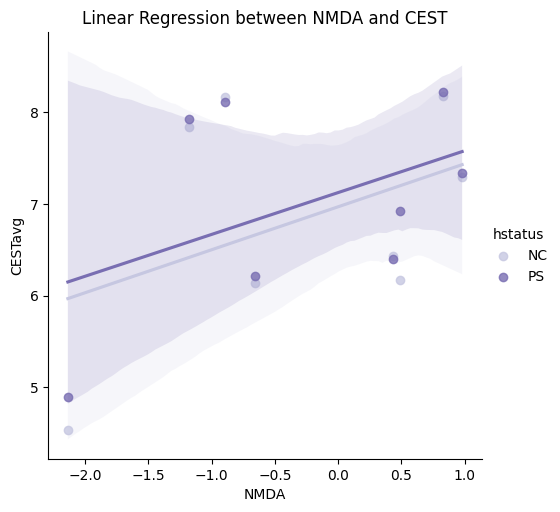

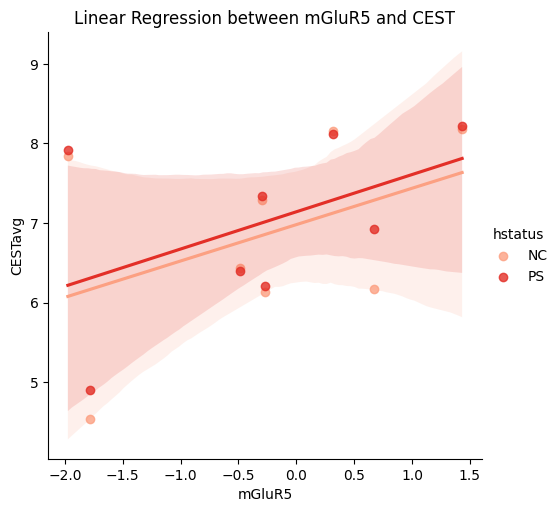

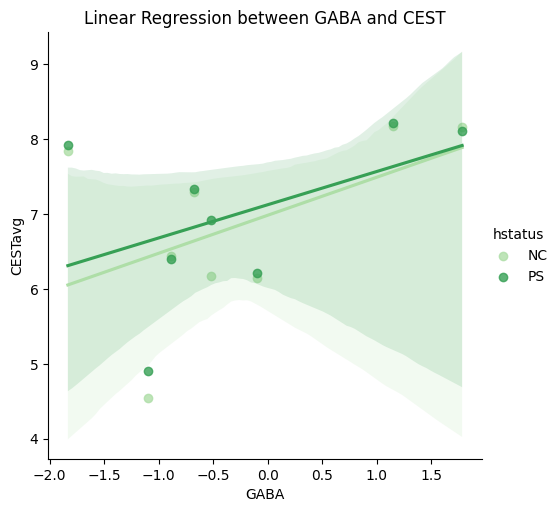

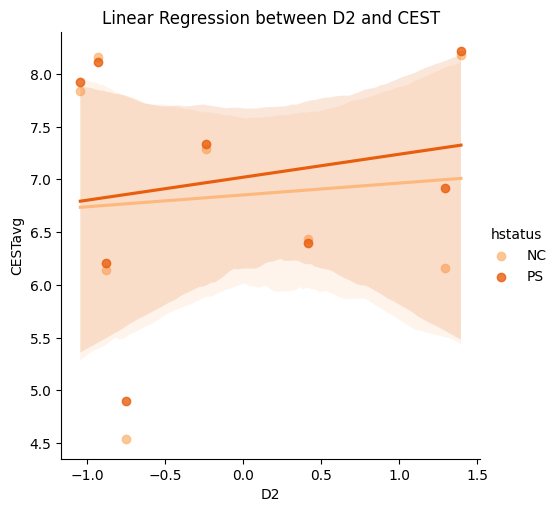

In [25]:
# Loop through nmaps and make correlation plots
#print(cestdf[CESTavg].max())

nmap_palette = {
    "NMDA": "Purples",   # Replace with actual nmap names and desired palettes
    "mGluR5": "Reds",
    "GABA": "Greens",
    "D2": "Oranges"
    # Add more mappings as needed
}

for nmap in nmaps:
    cestdf[nmap] = pd.to_numeric(cestdf[nmap], errors='coerce')
    cestdf['CESTavg'] = pd.to_numeric(cestdf['CESTavg'], errors='coerce')
    plot_data = cestdf.dropna(subset=[nmap, 'CESTavg'])
    palette = nmap_palette.get(nmap) # Default to "Set1" if nmap not in dictionary
    plot = sns.lmplot(x=nmap, y='CESTavg', hue='hstatus',data=plot_data, palette=palette) #
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 


In [22]:
for nmap in nmaps:
    for group in ["PS","NC"]:
        #graphdf = cestdf[cestdf["hstatus"]==group]
        graphdf = cestdf
        formula = f'CESTavg ~ {nmap}'
        rval, pval = pearsonr(graphdf[nmap],graphdf["CESTavg"])
        print(nmap)
        print("r=" + str(rval)," p=" + str(pval))


NMDA
r=0.4274864770879097  p=0.09860861608728594
NMDA
r=0.4274864770879097  p=0.09860861608728594
mGluR5
r=0.4437183214624255  p=0.08513655711172839
mGluR5
r=0.4437183214624255  p=0.08513655711172839
GABA
r=0.4712377812379669  p=0.06539626836376794
GABA
r=0.4712377812379669  p=0.06539626836376794
D2
r=0.13760488576930152  p=0.6113134694794503
D2
r=0.13760488576930152  p=0.6113134694794503


In [22]:
receptor_names = np.array(["NMDA","mGluR5","GABAa"])
np.save(path+'data/receptor_names_pet.npy', receptor_names)

# make final region x receptor matrix
receptor_data = np.zeros([nnodes, len(receptor_names)])


# NMDA Data
receptor_data[:, 0] = r[:, 0]


# plot each receptor map
if scale == 'scale1000_17':
    annot = datasets.fetch_schaefer2018('fsaverage')['1000Parcels17Networks']
    type(annot)
    print(annot)
    
    for k in range(len(receptor_names)):
        brain = plotting.plot_fsaverage(data=receptor_data[:, k],
                                        lhannot=annot.lh,
                                        rhannot=annot.rh,
                                        colormap='plasma',
                                        views=['lat', 'med'],
                                        data_kws={'representation': "wireframe"})
        brain.save_image(path+'figures/scale1000_17/surface_receptor_'+receptor_names[k]+'.png')

NameError: name 'path' is not defined